In [ ]:
import Module
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from intervaltree import Interval, IntervalTree

In [2]:
GRCh38_fasta = "data/GRCh38.fasta"
GRCh38_names = []
GRCh38_seqs = []

cur_name, cur_seq = "", []
with open(GRCh38_fasta, "r") as f:
    for line in tqdm(f, total=44284892, desc="Reading FASTA"):
        if line.startswith(">"):
            if cur_name:
                GRCh38_names.append(cur_name)
                GRCh38_seqs.append("".join(cur_seq))
                cur_name, cur_seq = "", []

            cur_name = line.split()[0][1:]
        else:
            cur_seq.append(line.strip())

    if cur_name:
        GRCh38_names.append(cur_name)
        GRCh38_seqs.append("".join(cur_seq))

Reading FASTA: 100%|██████████| 44284892/44284892 [00:48<00:00, 915155.98it/s] 


In [3]:
k_dict = 240
kmer_dict = defaultdict(list)

# 构建GRCh38的kmer字典
for i, seq in enumerate(GRCh38_seqs):
    # 保证序列不重叠即可
    cur_name = GRCh38_names[i]
    for j in tqdm(range(0, len(seq) - k_dict + 1, k_dict), desc=f"{cur_name}", leave=False):
        kmer = seq[j : j + k_dict]
        kmer_dict[kmer].append((i, j))

In [4]:
# 读取查询序列
Query_fasta = "data/query.fasta"
Query_seq = ""
with open(Query_fasta, "r") as f:
    for line in f:
        if not line.startswith(">"):
            Query_seq += line.strip()

In [5]:
class Result:
    def __init__(self, Query_pos, GRCh38_idx, GRCh38_pos):
        self.Query_pos = Query_pos
        self.GRCh38_idx = GRCh38_idx
        self.GRCh38_pos = GRCh38_pos

    def __iter__(self):
        return iter((self.Query_pos, self.GRCh38_idx, self.GRCh38_pos))


results: list[Result] = []

# 在GRCh38中查找Query序列的kmer
for i in range(0, len(Query_seq) - k_dict + 1):
    kmer = Query_seq[i : i + k_dict]
    if kmer in kmer_dict:
        for idx, pos in kmer_dict[kmer]:
            results.append(Result(i, idx, pos))

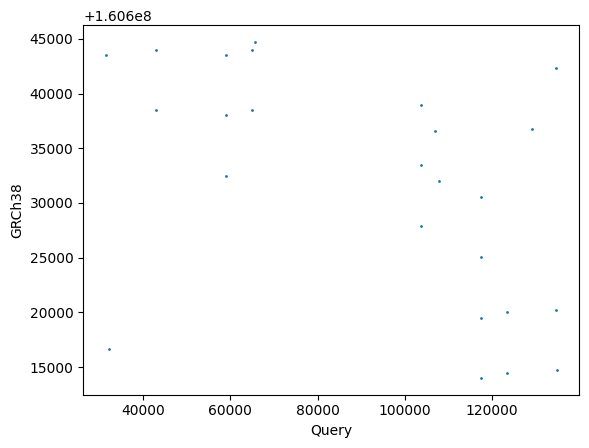

In [6]:
# 绘制查询结果散点图
fig, ax = plt.subplots()
for result in results:
    ax.scatter(result.Query_pos, result.GRCh38_pos, c="tab:blue", s=1)

ax.set_xlabel("Query")
ax.set_ylabel("GRCh38")
plt.show()

In [ ]:
class Match:
    def __init__(self, Query_pos, GRCh38_idx, GRCh38_pos, maxI, maxJ, maxVal, path, is_forward):
        self.Query_pos = Query_pos
        self.GRCh38_idx = GRCh38_idx
        self.GRCh38_pos = GRCh38_pos
        self.maxI = maxI
        self.maxJ = maxJ
        self.maxVal = maxVal
        self.path = path
        self.is_forward = is_forward

    def __iter__(self):
        return iter(
            (
                self.Query_pos,
                self.GRCh38_idx,
                self.GRCh38_pos,
                self.maxI,
                self.maxJ,
                self.maxVal,
                self.path,
                self.is_forward,
            )
        )


def extend_seq(k, result: Result, Query_seq, GRCh38_seqs, tol):
    """向左右延申序列"""
    match_list: list[Match] = []
    maxI, maxJ = 0, 0

    # 首先向右扩展
    que_pos, db_idx, db_pos = result
    (que_pos, db_pos) = (que_pos + k, db_pos + k)
    while True:
        # 确保选取的这段序列在范围内
        if que_pos + k > len(Query_seq) or db_pos + k > len(GRCh38_seqs[db_idx]):
            break

        # 截取正向kmer
        que_seq = Query_seq[que_pos : que_pos + k]
        db_seq = GRCh38_seqs[db_idx][db_pos : db_pos + k]

        # 计算得分矩阵 并回溯路径
        mat = Module.cal_score(que_seq, db_seq)
        maxI, maxJ, maxVal, path = Module.trace_back(que_seq, db_seq, mat)
        if maxVal < tol:
            break

        # 记录结果
        match_list.append(Match(que_pos, db_idx, db_pos, maxI, maxJ, maxVal, path, True))

        # 向右更新序列
        que_pos += maxI
        db_pos += maxJ

    # 然后向左扩展
    que_pos, db_idx, db_pos = result
    (que_pos, db_pos) = (que_pos - 1, db_pos - 1)
    while True:
        # 确保选取的这段序列在范围内
        if que_pos - k < 0 or db_pos - k < 0:
            break

        # 截取逆向kmer
        que_seq = Query_seq[que_pos : que_pos - k : -1]
        db_seq = GRCh38_seqs[db_idx][db_pos : db_pos - k : -1]

        # 计算得分矩阵 并回溯路径
        mat = Module.cal_score(que_seq, db_seq)
        maxI, maxJ, maxVal, path = Module.trace_back(que_seq, db_seq, mat)
        if maxVal < tol:
            break

        # 记录结果
        match_list.append(Match(que_pos, db_idx, db_pos, maxI, maxJ, maxVal, path, False))

        # 向左更新序列
        que_pos -= maxI
        db_pos -= maxJ

    # 按照Query的位置排序
    match_list.sort(key=lambda x: x.Query_pos)
    return match_list

In [ ]:
k_ext = 60
tol_score = 20

i = 0
marked = IntervalTree()
for result in results:
    # 如果此查询区间已计算, 则跳过
    if len(marked.overlap(result.Query_pos, result.Query_pos + k_dict)) > 0:
        continue

    # 左右扩展序列
    match_list = extend_seq(k_ext, result, Query_seq, GRCh38_seqs, tol_score)

    # 保存此次匹配结果
    total_score = 0
    with open(f"res/res_{i}.txt", "w") as f:
        for que_pos, db_idx, db_pos, maxI, maxJ, maxVal, path, is_forward in match_list:
            total_score += maxVal
            if not is_forward:
                que_seq = Query_seq[que_pos : que_pos - maxI : -1]
                db_seq = GRCh38_seqs[db_idx][db_pos : db_pos - maxJ : -1]
                f.write(f"Score: {maxVal}\n")
                f.write(f"que: [{que_pos - maxI + 1}:{que_pos + 1}]\n")
                f.write(f"db: [{db_pos - maxJ + 1}:{db_pos + 1}]\n")
                f.write(Module.format_path(que_seq, db_seq, path, is_forward))
            else:
                que_seq = Query_seq[que_pos : que_pos + maxI]
                db_seq = GRCh38_seqs[db_idx][db_pos : db_pos + maxJ]
                f.write(f"Score: {maxVal}\n")
                f.write(f"que: [{que_pos}:{que_pos + maxI}]\n")
                f.write(f"db: [{db_pos}:{db_pos + maxJ}]\n")
                f.write(Module.format_path(que_seq, db_seq, path, is_forward))

    # 计算总匹配区间的 起始和终止位置
    head_ans, tail_ans = match_list[0], match_list[-1]
    if not head_ans.is_forward:
        Query_start = head_ans.Query_pos - head_ans.maxI + 1
        GRCh38_start = head_ans.GRCh38_pos - head_ans.maxJ + 1
    else:
        Query_start = head_ans.Query_pos
        GRCh38_start = head_ans.GRCh38_pos

    if not tail_ans.is_forward:
        Query_end = tail_ans.Query_pos + tail_ans.maxI
        GRCh38_end = tail_ans.GRCh38_pos + tail_ans.maxJ
    else:
        Query_end = tail_ans.Query_pos + tail_ans.maxI
        GRCh38_end = tail_ans.GRCh38_pos + tail_ans.maxJ

    # 标记已计算的区间
    marked.add(Interval(Query_start, Query_end))

    print(f"Results {i}:")
    print(f"Score: {total_score}")
    print(f"Query: [{Query_start}:{Query_end}]")
    print(f"GRCh38: [{GRCh38_start}:{GRCh38_end}]")
    print("--------------------------------")
    print()

    i = i + 1

Results 0:
Score: 36079
Query: [13881:34927]
GRCh38: [160625899:160647017]
--------------------------------

Results 1:
Score: 79979
Query: [14:45910]
GRCh38: [160600884:160646982]
--------------------------------

Results 2:
Score: 63999
Query: [25457:63712]
GRCh38: [160609768:160648277]
--------------------------------

Results 3:
Score: 11582
Query: [61475:67918]
GRCh38: [160640473:160646992]
--------------------------------

Results 4:
Score: 17765
Query: [102239:111710]
GRCh38: [160637522:160647016]
--------------------------------

Results 5:
Score: 68836
Query: [96718:135089]
GRCh38: [160609815:160648310]
--------------------------------

